In [1]:
import cv2
import numpy as np
from easydict import EasyDict

root = "dataset\\kitti\\"
raw  = root + "object\\training\\"
img2 = raw + "image_2\\"
img3 = raw + "image_3\\"
lidar =raw + "velodyne\\"
calib =raw + "calib\\"

sample_id  = 1
image_name = f"{sample_id:06d}.png"
lidar_name = f"{sample_id:06d}.bin"
calib_name = f"{sample_id:06d}.txt"

boundary = EasyDict({
    "minX": 0,
    "maxX": 50,
    "minY": -25,
    "maxY": 25,
    "minZ": -2.73,
    "maxZ": 1.27
})
BEV_WIDTH = 608   # across y axis -25m ~ 25m
BEV_HEIGHT = 608  # across x axis 0m ~ 50m
DISCRETIZATION_X = (boundary.maxX - boundary.minX) / BEV_HEIGHT
DISCRETIZATION_Y = (boundary.maxY - boundary.minY) / BEV_HEIGHT

In [6]:
# Image
cim2 = cv2.imread(img2+image_name, cv2.IMREAD_COLOR)
cim3 = cv2.imread(img3+image_name, cv2.IMREAD_COLOR)
# print(type(cim2))
print(cim2.shape)

# axis 0: append below
# asix 1: append next
cv2.imshow(image_name, np.concatenate((cim2, cim3), axis=1))
cv2.waitKey(0)
cv2.destroyAllWindows()

(375, 1242, 3)


In [5]:
# lidar
lidar_data = np.fromfile(lidar+lidar_name, dtype=np.float32).reshape(-1, 4)

# remove boundary
## x, y, z = 0, 1, 2
mask = np.where(
    (lidar_data[:,0] >= boundary.minX) &
    (lidar_data[:,0] <= boundary.maxX) &

    (lidar_data[:,1] >= boundary.minY) &
    (lidar_data[:,1] <= boundary.maxY) &

    (lidar_data[:,2] >= boundary.minZ) &
    (lidar_data[:,2] <= boundary.maxZ)
)
lidar_data = lidar_data[mask]
lidar_data[:,2] -= boundary.minZ

# make BEV feature
height = BEV_HEIGHT + 1 # NOTE: why?
width  = BEV_WIDTH  + 1 # ?

## discretize
bev = np.copy(lidar_data)
bev[:,0] = np.int_(np.floor(bev[:,0] / DISCRETIZATION_X))
bev[:,1] = np.int_(np.floor(bev[:,1] / DISCRETIZATION_Y) + width / 2)

## x, y, -z로 정렬
indices = np.lexsort((-bev[:, 2], bev[:, 1], bev[:, 0]))
bev = bev[indices]

height_map    = np.zeros((height, width))
intensity_map = np.zeros((height, width))
density_map   = np.zeros((height, width))

_, indices, counts = np.unique(bev[:, 0:2], axis=0, return_index=True, return_counts=True)
bev_top = bev[indices]

## height
max_height = float(np.abs(boundary.maxZ - boundary.minZ))
height_map[np.int_(bev_top[:,0]), np.int_(bev_top[:,1])] = bev_top[:,2] / max_height

## intensity
intensity_map[np.int_(bev_top[:,0]), np.int_(bev_top[:,1])] = bev_top[:,3]

## density
## count수를 log_64 스케일로 변환
norm_counts = np.minimum(1.0, np.log(counts + 1) / np.log(64))
density_map[np.int_(bev_top[:,0]), np.int_(bev_top[:,1])] = norm_counts

rgb_map = np.zeros((3, height - 1, width - 1))              # height - 1, width - 1 = BEV_HEIGHT, BEV_WIDTH
rgb_map[2, :, :] = density_map[:BEV_HEIGHT, :BEV_WIDTH]     # r_map
rgb_map[1, :, :] = height_map[:BEV_HEIGHT, :BEV_WIDTH]      # g_map
rgb_map[0, :, :] = intensity_map[:BEV_HEIGHT, :BEV_WIDTH]   # b_map

# test = x[0].detach().to('cpu').numpy()
rgb_map_transpose = np.transpose(rgb_map, (1,2,0))
cv2.imwrite(lidar_name+".jpeg", rgb_map_transpose*255)
cv2.imshow(lidar_name, rgb_map_transpose); cv2.waitKey(0); cv2.destroyAllWindows();

np.linalg.inv(r0@tr)=array([[0.0002, 0.0104, 0.9999, 0.2729],
       [-0.9999, 0.0106, 0.0001, -0.0020],
       [-0.0106, -0.9999, 0.0105, -0.0723],
       [0.0000, 0.0000, 0.0000, 1.0000]])
(3, 4)
xy2.shape=(120268, 3)


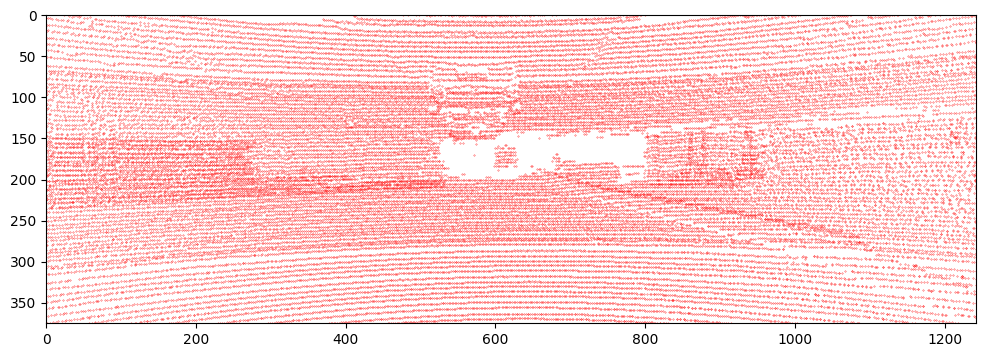

In [10]:
# lidar to image
with open(calib+calib_name, 'r') as cfile:
    calib_data = cfile.read()
calib_data = calib_data.strip()
calib_data = calib_data.split('\n')
# print(calib_data)

calib_dict = {}
for cd in calib_data:
    sp = cd.split(":")
    calib_dict[sp[0]] = sp[1].strip().split(" ")
# calib_dict

# read image
# cim2 = cv2.imread(img2+image_name, cv2.IMREAD_COLOR)
# cim3 = cv2.imread(img3+image_name, cv2.IMREAD_COLOR)

# read lidar
lidar_data = np.fromfile(lidar+lidar_name, dtype=np.float32).reshape(-1, 4)
## TODO find boundary
# mask = np.where(
#     (lidar_data[:,0] >= boundary.minX) &
#     (lidar_data[:,0] <= boundary.maxX) &

#     (lidar_data[:,1] >= boundary.minY) &
#     (lidar_data[:,1] <= boundary.maxY) &

#     (lidar_data[:,2] >= boundary.minZ) &
#     (lidar_data[:,2] <= boundary.maxZ)
# )
# lidar_data = lidar_data[mask]
# xyz = lidar_data[:,:3]

# mapping to image
p2 = np.array(list(map(float, calib_dict['P2']))).reshape(3, 4)
# print(f"{p2=}, {p2.shape}")
p3 = np.array(list(map(float, calib_dict['P3']))).reshape(3, 4)

r0 = np.eye(4)
r0[:3,:3] = np.array(list(map(float, calib_dict['R0_rect']))).reshape(3, 3)
# print(f"{r0=}, {r0.shape}")

tr = np.eye(4)
tr[:3,:4] = np.array(list(map(float, calib_dict['Tr_velo_to_cam']))).reshape(3, 4)
# print(f"{tr=}, {tr.shape}")

np.set_printoptions(formatter={'float_kind': "{:.4f}".format})
print(f"{r0@tr=}")

## get calib
xy2 = ((p2 @ r0) @ tr) @ lidar_data.transpose()
print((p2@r0).shape)
xy2 = xy2.transpose()
print(f"{xy2.shape=}")

# b_ones = np.ones((1,3), int)

s2 = xy2[:,2] # z
x2 = xy2[:,0] / s2
y2 = xy2[:,1] / s2

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4), dpi=100)
plt.plot(x2, y2, 'r.', markersize = 0.5)
# plt.gca().invert_yaxis()
# (375, 1242, 3)
plt.xlim(0, 1242)
plt.ylim(375, 0)
plt.show()

# cam_map = np.zeros((1, BEV_HEIGHT, BEV_WIDTH))
# cam_map[:, 0, :] = x2
# cam_map[:, :, 0] = y2
# cam_map = np.transpose(cam_map, (1,2,0))
# cv2.imshow("cam map", cam_map); cv2.waitKey(0); cv2.destroyAllWindows();